

## **Buisness Problem**: Retail Analysis (Cross-sell & Up-sell)



# **Dataset** 
(Online Retail.xlsx)

In [1]:
import numpy as np
import pandas as pd

In [2]:
! git clone https://github.com/Swapnil-Damate/Upselling-and-cross-selling-.git
#written by Swapnil

Cloning into 'Upselling-and-cross-selling-'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [3]:
dataset = pd.read_excel('/content/Upselling-and-cross-selling-/Online Retail.xlsx')
df = dataset.copy()
#written By Swapnil

## **Exploratory Data Analysis (EDA)**

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
 df=df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','Description','InvoiceDate','Country']]

In [6]:
       #Creating Total amount variable and adding it to dataset
TotalAmount=df['Quantity']*df['UnitPrice']
df.insert(loc=6,column='TotalAmount',value=TotalAmount)
df=df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','TotalAmount','Description','InvoiceDate','Country']]
df.head()

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom


In [7]:
                                                  #Total amount of purchases for each customer
new_df=df.groupby(['CustomerID']).sum()
new_df.sort_values('TotalAmount',ascending=False,inplace=True)
final_df = new_df[(new_df['Quantity']>0) & (new_df['TotalAmount'] > 0)]
final_df.head(10)

,Quantity,UnitPrice,TotalAmount
CustomerID,,,
14646.0,196719,5400.21,279489.02
18102.0,64122,5159.73,256438.49
17450.0,69029,3320.09,187482.17
14911.0,77180,31060.66,132572.62
12415.0,77242,2499.82,123725.45
14156.0,57025,6544.29,113384.14
17511.0,63012,2607.08,88125.38
16684.0,49390,709.93,65892.08
13694.0,61803,1163.81,62653.10


In [8]:
dff = df.copy()
dff = dff.drop('CustomerID',axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


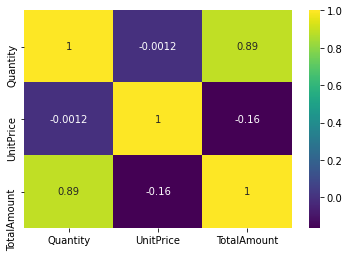

In [9]:
import seaborn as sns
sns.heatmap(dff.corr(),annot=True,cmap='viridis')

In [10]:
                                                             #Customer who paid most and least
print('Customer ID {} had paid maximum amount of {}'.format(int(final_df['TotalAmount'].argmax()),final_df['TotalAmount'].max()))
print('Customer ID {} had paid minimum amount of {}'.format(int(final_df['TotalAmount'].argmin()),final_df['TotalAmount'].min()))

Customer ID 0 had paid maximum amount of 279489.0199999999
Customer ID 4314 had paid minimum amount of 2.8999999999941792


In [11]:
                                                            #Maximum and Minimum no. of quantity and it's corresponding customer ID 
print('The maximum number of products has been bought is {} by customer id {}'.format(final_df['Quantity'].max(),final_df['Quantity'].argmax()))
print('The minimum number of product has been bought is {} by customer id {}'.format(final_df['Quantity'].min(),final_df['Quantity'].argmin()))

The maximum number of products has been bought is 196719 by customer id 0
The minimum number of product has been bought is 1 by customer id 858


In [12]:
                                            #Total sales at each country and how many quantities sold at each country
country=df.groupby(['Country']).sum()
country.sort_values('TotalAmount',ascending=False,inplace=True)
country.drop('CustomerID',axis=1,inplace=True)
country.head()

,Quantity,UnitPrice,TotalAmount
Country,,,
United Kingdom,4263829,2.245715e+06,8.187806e+06
Netherlands,200128,6.492550e+03,2.846615e+05
EIRE,142637,4.844719e+04,2.632768e+05
Germany,117448,3.766600e+04,2.216982e+05
France,110480,4.303199e+04,1.974039e+05


# **Data Cleaning / Data Preprocessing**

In [13]:
df.shape

(541909, 9)

In [14]:
df.describe()

,CustomerID,Quantity,UnitPrice,TotalAmount
count,406829.000000,541909.000000,541909.000000,541909.000000
mean,15287.690570,9.552250,4.611114,17.987795
std,1713.600303,218.081158,96.759853,378.810824
min,12346.000000,-80995.000000,-11062.060000,-168469.600000
25%,13953.000000,1.000000,1.250000,3.400000
50%,15152.000000,3.000000,2.080000,9.750000
75%,16791.000000,10.000000,4.130000,17.400000
max,18287.000000,80995.000000,38970.000000,168469.600000


In [15]:
#To remove extra spaces in Description if present
df['Description'] = df['Description'].str.strip()

In [16]:
#Drop NaN Entries
df.dropna()
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df.shape

(541909, 9)

In [17]:
#Remove cancelled/Retured Transaction
df = df[~df['InvoiceNo'].str.contains('C')]

df = df[~df['InvoiceNo'].str.contains('A')]


# **Feature Engineering**

In [18]:

df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 532618, dtype: datetime64[ns]

In [19]:
df['year']=df['InvoiceDate'].apply(lambda date:date.year)
df['month']=df['InvoiceDate'].apply(lambda date:date.month)

# **Evaluate Algorithm**

In [20]:
!pip install mlxtend==0.17.0
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

     |████████████████████████████████| 1.3MB 8.0MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [21]:
basket_Germany = (df[df['Country'] == 'Germany']
             .groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket_Germany.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket_Germany.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

## Apriori Algorithm

In [23]:
frequent_items = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(3 PIECE SPACEBOY COOKIE CUTTER SET),(ROUND SNACK BOXES SET OF4 WOODLAND),0.041575,0.245077,0.021882,0.526316,2.147556,0.011693,1.593727
1,(ROUND SNACK BOXES SET OF4 WOODLAND),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.245077,0.041575,0.021882,0.089286,2.147556,0.011693,1.052388
2,(6 RIBBONS RUSTIC CHARM),(CHOCOLATE BOX RIBBONS),0.102845,0.037199,0.021882,0.212766,5.719650,0.018056,1.223017
3,(CHOCOLATE BOX RIBBONS),(6 RIBBONS RUSTIC CHARM),0.037199,0.102845,0.021882,0.588235,5.719650,0.018056,2.178806
4,(6 RIBBONS RUSTIC CHARM),(PLASTERS IN TIN CIRCUS PARADE),0.102845,0.115974,0.024070,0.234043,2.018065,0.012143,1.154145


In [24]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.80) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,(BLUE POLKADOT BOWL),(RED RETROSPOT CUP),0.032823,0.070022,0.026258,0.800000,11.425000,0.023960,4.649891
65,(BLUE STRIPE CERAMIC DRAWER KNOB),(RED STRIPE CERAMIC DRAWER KNOB),0.028446,0.045952,0.024070,0.846154,18.413919,0.022763,6.201313
67,(BLUE STRIPE CERAMIC DRAWER KNOB),(WHITE SPOT RED CERAMIC DRAWER KNOB),0.028446,0.052516,0.024070,0.846154,16.112179,0.022576,6.158643
68,(PINK VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.024070,0.030635,0.024070,1.000000,32.642857,0.023333,inf
89,(CHARLOTTE BAG SUKI DESIGN),(WOODLAND CHARLOTTE BAG),0.045952,0.126915,0.037199,0.809524,6.378489,0.031367,4.583698
100,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.048140,0.050328,0.039387,0.818182,16.256917,0.036965,5.223195
111,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.039387,0.061269,0.035011,0.888889,14.507937,0.032598,8.448578
124,(DINOSAUR PARTY BAG + STICKER SET),(WOODLAND PARTY BAG + STICKER SET),0.021882,0.067834,0.021882,1.000000,14.741935,0.020398,inf
126,(DOLLY GIRL CHILDRENS BOWL),(DOLLY GIRL CHILDRENS CUP),0.026258,0.024070,0.024070,0.916667,38.083333,0.023438,11.711160
127,(DOLLY GIRL CHILDRENS CUP),(DOLLY GIRL CHILDRENS BOWL),0.024070,0.026258,0.024070,1.000000,38.083333,0.023438,inf


# FpGrowth Algorithm

In [25]:
frequent_items2 = fpgrowth(basket_sets,
                          min_support = 0.02, use_colnames = True)
rules2 = association_rules(frequent_items2, metric="lift", min_threshold=1)
rules2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG WOODLAND ANIMALS),(WOODLAND CHARLOTTE BAG),0.100656,0.126915,0.048140,0.478261,3.768366,0.035365,1.673414
1,(WOODLAND CHARLOTTE BAG),(JUMBO BAG WOODLAND ANIMALS),0.126915,0.100656,0.048140,0.379310,3.768366,0.035365,1.448942
2,(PLASTERS IN TIN WOODLAND ANIMALS),(JUMBO BAG WOODLAND ANIMALS),0.137856,0.100656,0.028446,0.206349,2.050035,0.014570,1.133173
3,(JUMBO BAG WOODLAND ANIMALS),(PLASTERS IN TIN WOODLAND ANIMALS),0.100656,0.137856,0.028446,0.282609,2.050035,0.014570,1.201777
4,(JUMBO BAG WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.100656,0.245077,0.037199,0.369565,1.507958,0.012531,1.197465


In [26]:
Rules = rules2[ (rules2['lift'] >= 6) &
       (rules2['confidence'] >= 0.80) ]
Rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.035011,0.063457,0.032823,0.93750,14.773707,0.030601,14.984683
45,"(JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG)",(JUMBO BAG WOODLAND ANIMALS),0.024070,0.100656,0.024070,1.00000,9.934783,0.021647,inf
159,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.84375,6.648168,0.050194,5.587746
171,"(RED RETROSPOT CHARLOTTE BAG, ROUND SNACK BOXE...",(WOODLAND CHARLOTTE BAG),0.030635,0.126915,0.030635,1.00000,7.879310,0.026747,inf
177,"(SPACEBOY LUNCH BOX, RED RETROSPOT CHARLOTTE BAG)",(WOODLAND CHARLOTTE BAG),0.021882,0.126915,0.021882,1.00000,7.879310,0.019105,inf


# Result Visualization

In [27]:
#result.to_excel('/content/drive/My Drive/Internship Model Result/Final_retail_result.xlsx')
final_Table = pd.read_excel('/content/Upselling-and-cross-selling-/Final_onlineretail_result.xlsx')
final_Table = final_Table.drop('Unnamed: 0', axis=1)
final_Table = final_Table.drop('Unnamed: 0.1', axis=1)
final_Table = final_Table.replace()
final_Table

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,JAM JAR WITH GREEN LID,JAM JAR WITH PINK LID,0.035011,0.063457,0.032823,0.937500,14.773707,0.030601,14.984683
1,"JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG",JUMBO BAG WOODLAND ANIMALS,0.024070,0.100656,0.024070,1.000000,9.934783,0.021647,inf
2,RED RETROSPOT CHARLOTTE BAG,WOODLAND CHARLOTTE BAG,0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
3,"ROUND SNACK BOXES SET OF4 WOODLAND, RED RETROS...",WOODLAND CHARLOTTE BAG,0.030635,0.126915,0.030635,1.000000,7.879310,0.026747,inf
4,"RED RETROSPOT CHARLOTTE BAG, SPACEBOY LUNCH BOX",WOODLAND CHARLOTTE BAG,0.021882,0.126915,0.021882,1.000000,7.879310,0.019105,inf
5,"RED RETROSPOT CHARLOTTE BAG, RED TOADSTOOL LED...",WOODLAND CHARLOTTE BAG,0.024070,0.126915,0.024070,1.000000,7.879310,0.021015,inf
6,"JUMBO BAG WOODLAND ANIMALS, RED RETROSPOT CHAR...",WOODLAND CHARLOTTE BAG,0.024070,0.126915,0.021882,0.909091,7.163009,0.018827,9.603939
7,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,0.035011,0.078775,0.032823,0.937500,11.901042,0.030065,14.739606
8,"JUMBO BAG WOODLAND ANIMALS, JUMBO BAG PINK POL...",JUMBO BAG RED RETROSPOT,0.026258,0.078775,0.026258,1.000000,12.694444,0.024190,inf
9,"JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROSPOT",JUMBO BAG WOODLAND ANIMALS,0.032823,0.100656,0.026258,0.800000,7.947826,0.022954,4.496718


## Model

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3, max_features=None,
                      strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      stop_words='english')

tfv_matrix = tfv.fit_transform(final_Table['consequents'])

from sklearn.metrics.pairwise import sigmoid_kernel

sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

indices = pd.Series(final_Table.index, index=final_Table['antecedents']).drop_duplicates()

#FUNCTION
def recc_me(title, sig=sig):
  idx = indices[title]
  sig_scores=list(enumerate(sig[idx]))
  sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
  sig_scores = sig_scores[1:3]
  recc_indices = [i[0] for i in sig_scores]
  return final_Table['antecedents'].iloc[recc_indices]

In [29]:
sig.shape

(39, 39)

In [30]:
indices

antecedents
JAM JAR WITH GREEN LID                                                  0
JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG                         1
RED RETROSPOT CHARLOTTE BAG                                             2
ROUND SNACK BOXES SET OF4 WOODLAND, RED RETROSPOT CHARLOTTE BAG         3
RED RETROSPOT CHARLOTTE BAG, SPACEBOY LUNCH BOX                         4
RED RETROSPOT CHARLOTTE BAG, RED TOADSTOOL LED NIGHT LIGHT              5
JUMBO BAG WOODLAND ANIMALS, RED RETROSPOT CHARLOTTE BAG                 6
JUMBO BAG PINK POLKADOT                                                 7
JUMBO BAG WOODLAND ANIMALS, JUMBO BAG PINK POLKADOT                     8
JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROSPOT                        9
BLUE POLKADOT CUP, RED RETROSPOT PLATE                                 10
BLUE POLKADOT BOWL                                                     11
PLASTERS IN TIN CIRCUS PARADE, RED TOADSTOOL LED NIGHT LIGHT           12
SWEETHEART CERAMIC TRINKET

In [31]:
cross_sell = recc_me('STRAWBERRY CHARLOTTE BAG')
Recomend = pd.DataFrame(cross_sell)
Recomend.head()

,antecedents
3,"ROUND SNACK BOXES SET OF4 WOODLAND, RED RETROS..."
4,"RED RETROSPOT CHARLOTTE BAG, SPACEBOY LUNCH BOX"


# UPSELL